<a href="https://colab.research.google.com/github/koh-hongQ/Understanding_ML_with_Math/blob/main/MLwithMath_MLP%EC%9D%B4%EB%AF%B8%EC%A7%80%EB%B6%84%EB%A5%98_250608.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 수학으로 이해하는 기계학습

*   수학과 고홍규




# HW : 이미지 분류 실습 (MLP)

### 이 실습에서는 MLP 기반 이미지 분류기를 직접 설계하고 학습시켜봅니다.
- 다양한 기법을 실험하면서 성능을 비교합니다.
- 자유롭게 모델을 개선하고 최적의 성능을 찾아보세요!
- 아래의 코드는 데이터를 불러오는 예시 코드입니다(수정가능).
- Tensorflow 혹은 Pytouch, 더 나아가 Numpy 코딩도 가능합니다.

> ⚠️ 주의 필독

- `모든 문제에서 validation dataset은 train dataset의 10%로 고정!`
- `Test set 변경 불가능 및 학습 과정에서 모델에 노출되면 0점 처리`
- 최종 제출하는 model parameter로 재구현했을 때, 해당 성능과 근접하게 안나오면 `과제 전체 0점 처리`

In [ ]:
## 참고하세요. CIFAR-10은 다양한 방법으로 구할 수 있습니다. 예를 들어 다음과 같습니다.

from tensorflow.keras.datasets import cifar10

# 데이터 로드
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
## 참고하세요. fashion_mnist은 다양한 방법으로 구할 수 있습니다.

from tensorflow.keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# 혹은 아래처럼 해도 됩니다.

import torch
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

def get_data_loaders(data_name, batch_size=64, valid_ratio=0.1):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Fashion-MNIST 데이터셋 다운로드 (train, test)
    if data_name == "FashionMNIST":
      full_train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
      test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

    elif data_name =="CIFAR10":
      full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
      test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Train/Validation split
    n_total = len(full_train_dataset)
    n_valid = int(n_total * valid_ratio)
    n_train = n_total - n_valid
    train_dataset, valid_dataset = random_split(full_train_dataset, [n_train, n_valid])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Train samples: {n_train}, Validation samples: {n_valid}, Test samples: {len(test_dataset)}")
    return train_loader, valid_loader, test_loader

# DataLoader 실행 예시
train_loader, valid_loader, test_loader = get_data_loaders(data_name="CIFAR10",batch_size=64)



100%|██████████| 170M/170M [00:02<00:00, 80.2MB/s]


Train samples: 45000, Validation samples: 5000, Test samples: 10000


# 문제 1 : 데이터 시각화 및 복잡도

- 사용할 데이터셋: `CIFAR-10'과 `FashionMNIST` 둘 다 활용합니다.
- Q1. 모든 클래스에 대해 대표 이미지를 1장씩 시각화하시오.
- Q2. 두 데이터셋 중 동일한 layer 수를 갖는 MLP 모델이 분류하기 쉬운 데이터셋을 고르고, 그에 대한 근거를 제시하시오.

Train samples: 45000, Validation samples: 5000, Test samples: 10000


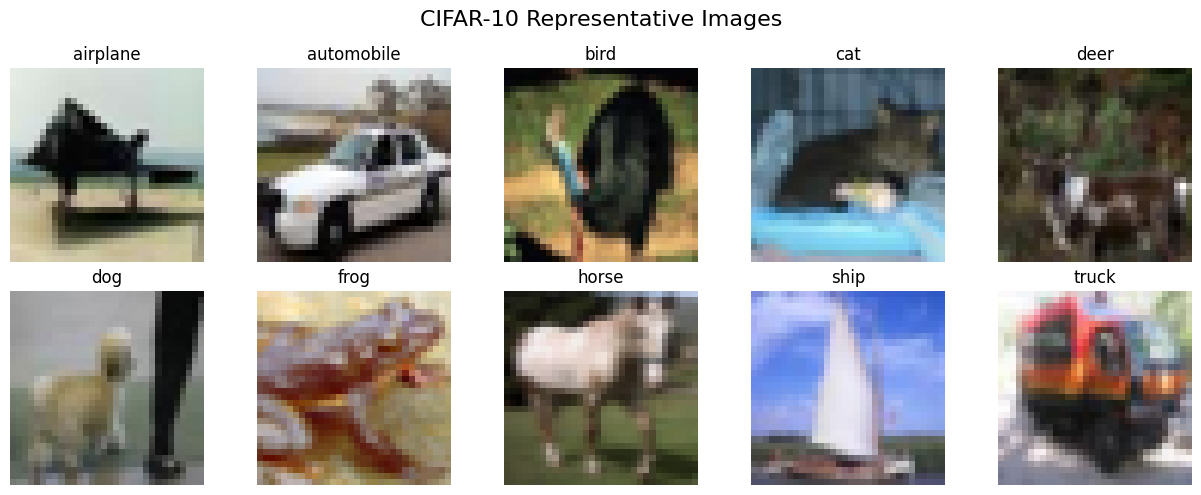

100%|██████████| 26.4M/26.4M [00:01<00:00, 19.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 294kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.47MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.92MB/s]


Train samples: 54000, Validation samples: 6000, Test samples: 10000


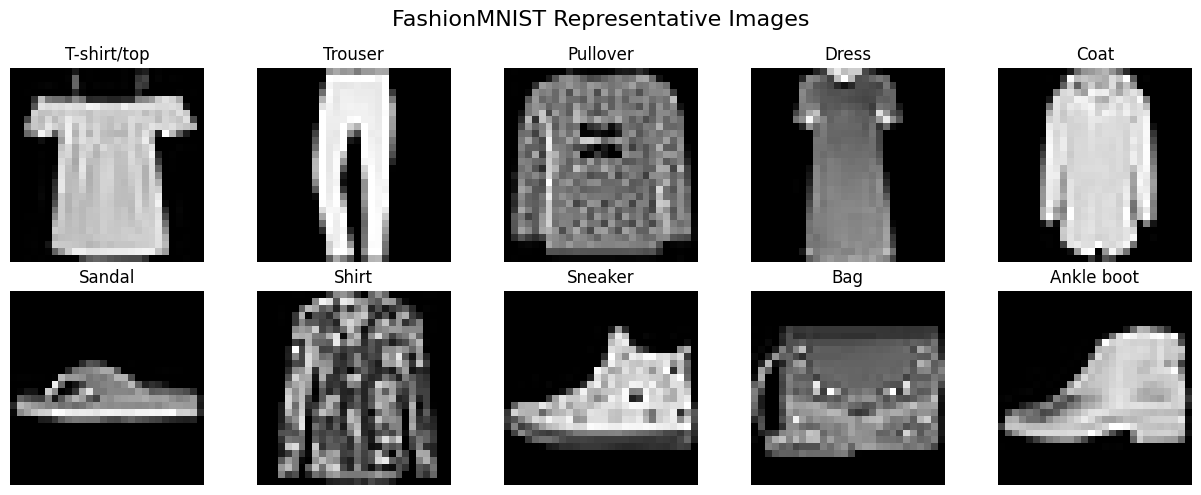

In [ ]:
import matplotlib.pyplot as plt

# plt.subplots(rows, cols, figsize=(cols*2.5, rows*2.5))
# subplots을 사용해서 각 데이터의 이미지들을 한번에 볼 수 있게 시각화해주세요.

import torch
import torchvision
from torchvision import transforms

# 클래스 이름 정의
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']
fashionmnist_classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 대표 이미지 수집 함수
def collect_representative_images(data_loader, num_classes):
    found = [False] * num_classes
    images = [None] * num_classes
    for imgs, labels in data_loader:
        for img, label in zip(imgs, labels):
            label = int(label)
            if not found[label]:
                images[label] = img
                found[label] = True
            if all(found):
                return images
    return images

# 시각화 함수
def visualize(images, class_names, title, is_grayscale=False):
    rows, cols = 2, 5
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
    for i, ax in enumerate(axes.flat):
        img = images[i]
        if is_grayscale:
            ax.imshow(img.squeeze(), cmap='gray')
        else:
            ax.imshow(img.permute(1, 2, 0))  # (C, H, W) → (H, W, C)
        ax.set_title(class_names[i])
        ax.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# DataLoader 함수 (이미 주신 것 활용)
def get_data_loaders(data_name, batch_size=64, valid_ratio=0.1):
    transform = transforms.Compose([transforms.ToTensor()])
    if data_name == "FashionMNIST":
        full_train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    elif data_name == "CIFAR10":
        full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    n_total = len(full_train_dataset)
    n_valid = int(n_total * valid_ratio)
    n_train = n_total - n_valid
    train_dataset, valid_dataset = torch.utils.data.random_split(full_train_dataset, [n_train, n_valid])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f"Train samples: {n_train}, Validation samples: {n_valid}, Test samples: {len(test_dataset)}")
    return train_loader, valid_loader, test_loader

# 실제 실행
# CIFAR-10
train_loader_cifar, _, _ = get_data_loaders("CIFAR10")
cifar_images = collect_representative_images(train_loader_cifar, 10)
visualize(cifar_images, cifar10_classes, "CIFAR-10 Representative Images")

# FashionMNIST
train_loader_fashion, _, _ = get_data_loaders("FashionMNIST")
fashion_images = collect_representative_images(train_loader_fashion, 10)
visualize(fashion_images, fashionmnist_classes, "FashionMNIST Representative Images", is_grayscale=True)


# 문제 2: Logistic Regression vs MLP + Softmax 비교 실험

이 문제에서는 Logistic regression 모델과 MLP 모델을 구성하고, 두 데이터셋을 학습 및 평가합니다.  


- 사용할 데이터셋: `CIFAR-10`, `FashionMNIST` 둘 다 활용합니다.
- **Logistic Regression:** : 1개의 선형 layer + softmax activation 사용
- **MLP:** : 3개의 hidden layer를 사용 (각 hidden layer의 dimension은 100, activation function은 sigmid 함수를 사용합니다.)


<br>
<br>

---

<br>

**모델 구조 및 하이퍼파라미터 조건**

| 모델                | 구성 요소                                            | Epochs | Batch size | Learning rate | Optimizer |
|---------------------|------------------------------------------------------|--------|------------|---------------|-----------|
| Logistic Regression | 1개의 선형 레이어                                    | 10     | 128        | 0.01          | SGD       |
| MLP                 | 3개의 hidden layer (dimension size 100, 활성함수: sigmoid)        | 10     | 128        | 0.01          | SGD       |

> ⚠️ 주의: 설정을 따르지 않을 경우 문제 0점 처리.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

# 공통 하이퍼파라미터
EPOCHS = 10
BATCH_SIZE = 128
LR = 0.01
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로더 함수
def get_data_loaders(data_name):
    transform = transforms.Compose([transforms.ToTensor()])
    if data_name == "FashionMNIST":
        train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
        input_size = 28 * 28
    elif data_name == "CIFAR10":
        train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
        input_size = 32 * 32 * 3

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    return train_loader, test_loader, input_size

# 모델 정의
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, num_classes=10):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.linear(x)  # CrossEntropyLoss에 softmax 포함되어 있음

class MLPModel(nn.Module):
    def __init__(self, input_dim, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.output = nn.Linear(100, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return self.output(x)  # CrossEntropyLoss에 softmax 포함됨

# 학습 및 평가 함수

def train_and_evaluate(model, train_loader, test_loader, model_name="", dataset_name=""):
    model.to(DEVICE)
    optimizer = optim.SGD(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    test_accuracies = []

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        avg_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Evaluation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total * 100
        test_accuracies.append(accuracy)
        print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {avg_train_loss:.4f}, Test Acc: {accuracy:.2f}%")

    # 그래프 그리기
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{model_name} Train Loss ({dataset_name})")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{model_name} Test Accuracy ({dataset_name})")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return test_accuracies[-1]

Epoch 1/10 - Train Loss: 2.2146, Test Acc: 35.23%
Epoch 2/10 - Train Loss: 1.9628, Test Acc: 35.03%
Epoch 3/10 - Train Loss: 1.9386, Test Acc: 35.93%
Epoch 4/10 - Train Loss: 1.9351, Test Acc: 36.94%
Epoch 5/10 - Train Loss: 1.9392, Test Acc: 35.68%
Epoch 6/10 - Train Loss: 1.9329, Test Acc: 35.92%
Epoch 7/10 - Train Loss: 1.9285, Test Acc: 34.95%
Epoch 8/10 - Train Loss: 1.9304, Test Acc: 35.85%
Epoch 9/10 - Train Loss: 1.9276, Test Acc: 34.77%
Epoch 10/10 - Train Loss: 1.9268, Test Acc: 36.54%


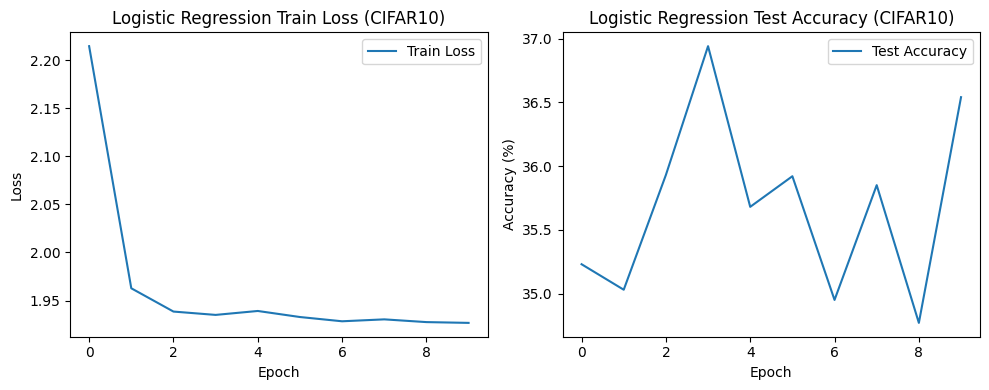

Epoch 1/10 - Train Loss: 2.3015, Test Acc: 11.17%
Epoch 2/10 - Train Loss: 2.3008, Test Acc: 13.18%
Epoch 3/10 - Train Loss: 2.3000, Test Acc: 10.00%
Epoch 4/10 - Train Loss: 2.2991, Test Acc: 10.00%
Epoch 5/10 - Train Loss: 2.2979, Test Acc: 10.20%
Epoch 6/10 - Train Loss: 2.2966, Test Acc: 10.87%
Epoch 7/10 - Train Loss: 2.2948, Test Acc: 15.70%
Epoch 8/10 - Train Loss: 2.2925, Test Acc: 20.13%
Epoch 9/10 - Train Loss: 2.2892, Test Acc: 16.11%
Epoch 10/10 - Train Loss: 2.2850, Test Acc: 15.77%


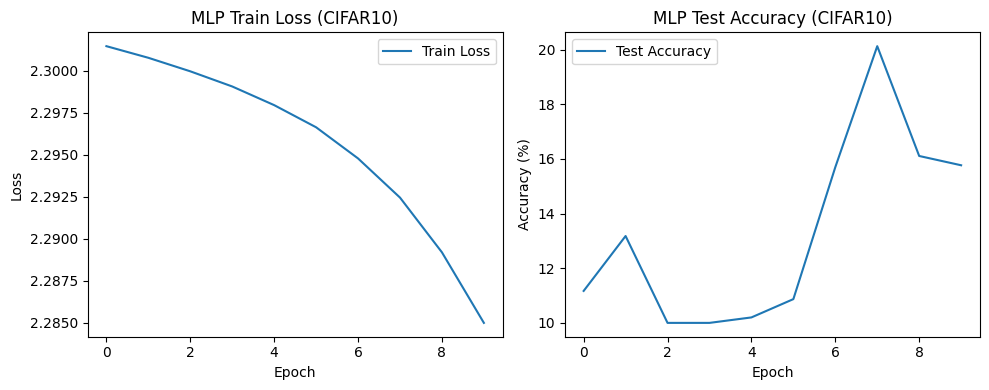

In [ ]:
acc_logistic = train_and_evaluate(logistic_model, train_loader, test_loader,
                                  model_name="Logistic Regression", dataset_name=dataset_name)

acc_mlp = train_and_evaluate(mlp_model, train_loader, test_loader,
                             model_name="MLP", dataset_name=dataset_name)



## 문제 3: MLP에 정규화 기법 적용

이번 문제에서는 문제 1에서 만든 MLP 모델에 정규화 기법들을 적용해 봅시다.


<br>

**모델 구조 및 하이퍼파라미터 조건**

| 모델                | 구성 요소                                            | Epochs | Batch size | Learning rate | Optimizer |
|---------------------|------------------------------------------------------|--------|------------|---------------|-----------|
| MLP | 3개의 hidden layer (dimension size 100, 활성함수: sigmoid)                                    | 30     | 128        | 0.01          | SGD       |
| MLP + Regularization                 | 각 layer에 batch norm, dropout 적용, L2 Regularization 적용        | 30     | 128        | 0.01          | SGD       |


> ⚠️ 주의: 설정을 따르지 않을 경우 문제 0점 처리.
<br>

---

<br>

## 보고서 작성 내용
두 데이터셋에 대해서  MLP 모델과 정규화를 추가한 모델의 의 train valdation에 대한 learning curve를 그리고, 분석하시오.

[FashionMNIST] MLP Epoch 1/30 - Loss: 2.3048, Val Acc: 10.00%
[FashionMNIST] MLP Epoch 2/30 - Loss: 2.3030, Val Acc: 10.00%
[FashionMNIST] MLP Epoch 3/30 - Loss: 2.3028, Val Acc: 10.00%
[FashionMNIST] MLP Epoch 4/30 - Loss: 2.3027, Val Acc: 10.00%
[FashionMNIST] MLP Epoch 5/30 - Loss: 2.3024, Val Acc: 14.21%
[FashionMNIST] MLP Epoch 6/30 - Loss: 2.3022, Val Acc: 11.76%
[FashionMNIST] MLP Epoch 7/30 - Loss: 2.3020, Val Acc: 10.00%
[FashionMNIST] MLP Epoch 8/30 - Loss: 2.3019, Val Acc: 10.00%
[FashionMNIST] MLP Epoch 9/30 - Loss: 2.3017, Val Acc: 10.00%
[FashionMNIST] MLP Epoch 10/30 - Loss: 2.3015, Val Acc: 10.03%
[FashionMNIST] MLP Epoch 11/30 - Loss: 2.3011, Val Acc: 10.00%
[FashionMNIST] MLP Epoch 12/30 - Loss: 2.3009, Val Acc: 10.00%
[FashionMNIST] MLP Epoch 13/30 - Loss: 2.3005, Val Acc: 10.00%
[FashionMNIST] MLP Epoch 14/30 - Loss: 2.3001, Val Acc: 17.81%
[FashionMNIST] MLP Epoch 15/30 - Loss: 2.2997, Val Acc: 10.00%
[FashionMNIST] MLP Epoch 16/30 - Loss: 2.2992, Val Acc: 10.00%
[

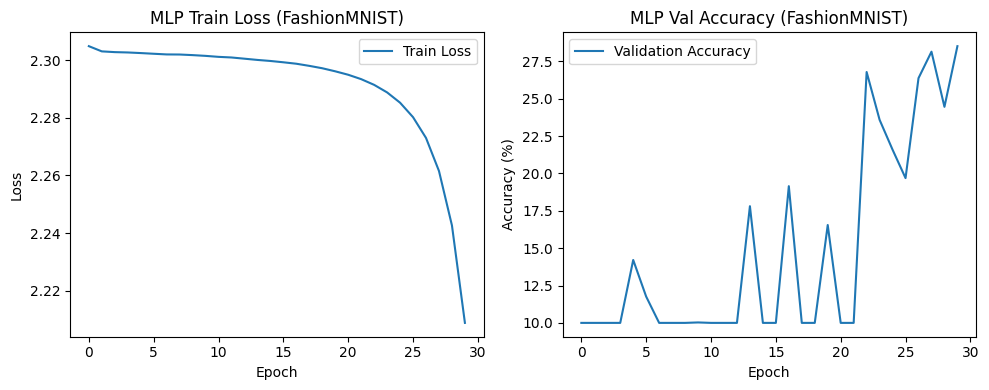

[CIFAR10] MLP Epoch 1/30 - Loss: 2.3048, Val Acc: 10.00%
[CIFAR10] MLP Epoch 2/30 - Loss: 2.3030, Val Acc: 10.00%
[CIFAR10] MLP Epoch 3/30 - Loss: 2.3031, Val Acc: 10.07%
[CIFAR10] MLP Epoch 4/30 - Loss: 2.3030, Val Acc: 10.00%
[CIFAR10] MLP Epoch 5/30 - Loss: 2.3030, Val Acc: 10.00%
[CIFAR10] MLP Epoch 6/30 - Loss: 2.3030, Val Acc: 10.00%
[CIFAR10] MLP Epoch 7/30 - Loss: 2.3029, Val Acc: 10.00%
[CIFAR10] MLP Epoch 8/30 - Loss: 2.3027, Val Acc: 10.00%
[CIFAR10] MLP Epoch 9/30 - Loss: 2.3027, Val Acc: 10.00%
[CIFAR10] MLP Epoch 10/30 - Loss: 2.3027, Val Acc: 10.00%
[CIFAR10] MLP Epoch 11/30 - Loss: 2.3028, Val Acc: 10.00%
[CIFAR10] MLP Epoch 12/30 - Loss: 2.3027, Val Acc: 10.04%
[CIFAR10] MLP Epoch 13/30 - Loss: 2.3026, Val Acc: 10.00%
[CIFAR10] MLP Epoch 14/30 - Loss: 2.3026, Val Acc: 10.00%
[CIFAR10] MLP Epoch 15/30 - Loss: 2.3026, Val Acc: 10.00%
[CIFAR10] MLP Epoch 16/30 - Loss: 2.3025, Val Acc: 10.00%
[CIFAR10] MLP Epoch 17/30 - Loss: 2.3024, Val Acc: 10.00%
[CIFAR10] MLP Epoch 18/

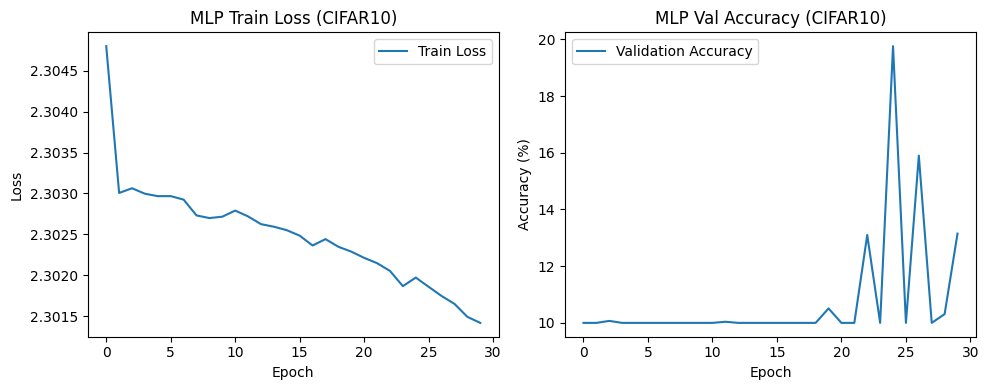

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# 공통 하이퍼파라미터
EPOCHS = 30
BATCH_SIZE = 128
LR = 0.01
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로더 함수 (예: FashionMNIST)
def get_data_loaders(data_name):
    transform = transforms.Compose([transforms.ToTensor()])
    if data_name == "FashionMNIST":
        train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
        input_size = 28 * 28
    elif data_name == "CIFAR10":
        train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
        input_size = 32 * 32 * 3

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    return train_loader, test_loader, input_size


# 문제 2 MLP 모델 (기본)
class MLPModel(nn.Module):
    def __init__(self, input_dim, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.output = nn.Linear(100, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return self.output(x)


# 문제 3: MLP + 정규화 기법 적용 모델
class MLPModle_Reg(nn.Module):
    def __init__(self, input_dim, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(100, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(100, 100)
        self.bn3 = nn.BatchNorm1d(100)
        self.dropout3 = nn.Dropout(0.5)

        self.output = nn.Linear(100, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)

        x = torch.sigmoid(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = torch.sigmoid(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = torch.sigmoid(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        return self.output(x)


# 학습 및 평가 + 그래프 저장
def train_and_evaluate(model, train_loader, test_loader, model_name, dataset_name):
    model.to(DEVICE)
    optimizer = optim.SGD(model.parameters(), lr=LR, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_accuracies = []

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        avg_loss = running_loss / len(train_loader.dataset)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total * 100
        val_accuracies.append(accuracy)

        print(f"[{dataset_name}] {model_name} Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}, Val Acc: {accuracy:.2f}%")

    # 그래프
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Train Loss ({dataset_name})')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{model_name} Val Accuracy ({dataset_name})')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return val_accuracies[-1]


# 실행
if __name__ == "__main__":
    for dataset_name in ["FashionMNIST", "CIFAR10"]:
        train_loader, test_loader, input_size = get_data_loaders(dataset_name)

        # 1. 기본 MLP
        model1 = MLPModel(input_size)
        acc1 = train_and_evaluate(model1, train_loader, test_loader, "MLP", dataset_name)

        # # 2. 정규화 MLP
        # model2 = MLPModel_Reg(input_size)
        # acc2 = train_and_evaluate(model2, train_loader, test_loader, "MLP + Regularization", dataset_name)



[FashionMNIST] MLP + Regularization Epoch 1/30 - Loss: 2.3078, Val Acc: 53.00%
[FashionMNIST] MLP + Regularization Epoch 2/30 - Loss: 2.2152, Val Acc: 61.30%
[FashionMNIST] MLP + Regularization Epoch 3/30 - Loss: 2.0836, Val Acc: 53.70%
[FashionMNIST] MLP + Regularization Epoch 4/30 - Loss: 1.9359, Val Acc: 52.36%
[FashionMNIST] MLP + Regularization Epoch 5/30 - Loss: 1.8093, Val Acc: 55.24%
[FashionMNIST] MLP + Regularization Epoch 6/30 - Loss: 1.7168, Val Acc: 59.19%
[FashionMNIST] MLP + Regularization Epoch 7/30 - Loss: 1.6524, Val Acc: 58.31%
[FashionMNIST] MLP + Regularization Epoch 8/30 - Loss: 1.6018, Val Acc: 57.57%
[FashionMNIST] MLP + Regularization Epoch 9/30 - Loss: 1.5591, Val Acc: 59.89%
[FashionMNIST] MLP + Regularization Epoch 10/30 - Loss: 1.5289, Val Acc: 60.27%
[FashionMNIST] MLP + Regularization Epoch 11/30 - Loss: 1.5006, Val Acc: 59.31%
[FashionMNIST] MLP + Regularization Epoch 12/30 - Loss: 1.4762, Val Acc: 60.58%
[FashionMNIST] MLP + Regularization Epoch 13/30 -

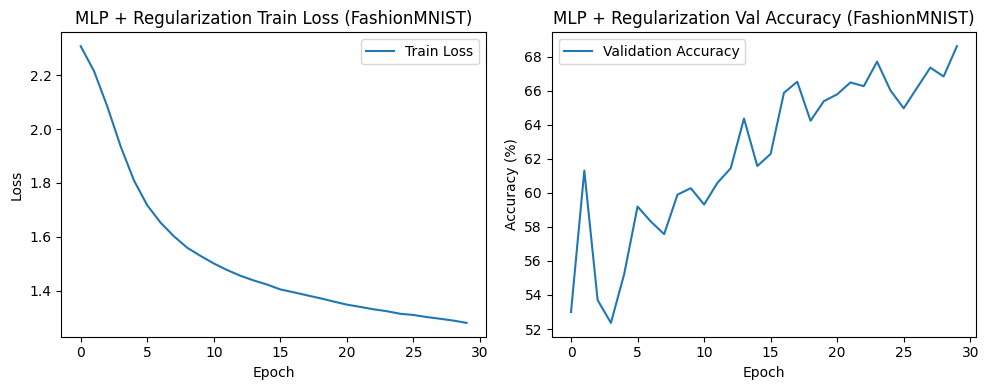

[CIFAR10] MLP + Regularization Epoch 1/30 - Loss: 2.3303, Val Acc: 24.31%
[CIFAR10] MLP + Regularization Epoch 2/30 - Loss: 2.2966, Val Acc: 20.46%
[CIFAR10] MLP + Regularization Epoch 3/30 - Loss: 2.2646, Val Acc: 22.50%
[CIFAR10] MLP + Regularization Epoch 4/30 - Loss: 2.2289, Val Acc: 22.88%
[CIFAR10] MLP + Regularization Epoch 5/30 - Loss: 2.2015, Val Acc: 21.36%
[CIFAR10] MLP + Regularization Epoch 6/30 - Loss: 2.1716, Val Acc: 23.15%
[CIFAR10] MLP + Regularization Epoch 7/30 - Loss: 2.1545, Val Acc: 22.52%
[CIFAR10] MLP + Regularization Epoch 8/30 - Loss: 2.1423, Val Acc: 22.85%
[CIFAR10] MLP + Regularization Epoch 9/30 - Loss: 2.1330, Val Acc: 21.27%
[CIFAR10] MLP + Regularization Epoch 10/30 - Loss: 2.1241, Val Acc: 21.79%
[CIFAR10] MLP + Regularization Epoch 11/30 - Loss: 2.1224, Val Acc: 22.77%
[CIFAR10] MLP + Regularization Epoch 12/30 - Loss: 2.1163, Val Acc: 23.05%
[CIFAR10] MLP + Regularization Epoch 13/30 - Loss: 2.1076, Val Acc: 22.77%
[CIFAR10] MLP + Regularization Epo

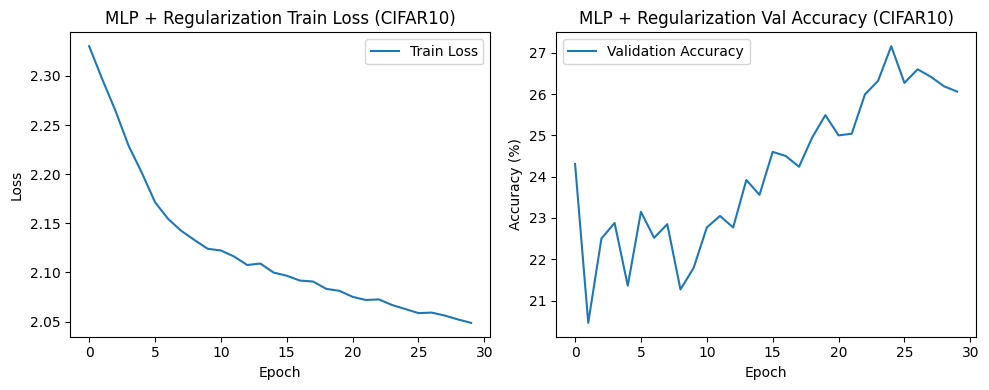

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# 공통 하이퍼파라미터
EPOCHS = 30
BATCH_SIZE = 128
LR = 0.01
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로더 함수 (예: FashionMNIST)
def get_data_loaders(data_name):
    transform = transforms.Compose([transforms.ToTensor()])
    if data_name == "FashionMNIST":
        train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
        input_size = 28 * 28
    elif data_name == "CIFAR10":
        train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
        input_size = 32 * 32 * 3

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    return train_loader, test_loader, input_size


# 문제 2 MLP 모델 (기본)
class MLPModel(nn.Module):
    def __init__(self, input_dim, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 100)
        self.output = nn.Linear(100, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return self.output(x)


# 문제 3: MLP + 정규화 기법 적용 모델
class MLPModel_Reg(nn.Module):
    def __init__(self, input_dim, num_classes=10):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 100)
        self.bn1 = nn.BatchNorm1d(100)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(100, 100)
        self.bn2 = nn.BatchNorm1d(100)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(100, 100)
        self.bn3 = nn.BatchNorm1d(100)
        self.dropout3 = nn.Dropout(0.5)

        self.output = nn.Linear(100, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)

        x = torch.sigmoid(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = torch.sigmoid(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        x = torch.sigmoid(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        return self.output(x)


# 학습 및 평가 + 그래프 저장
def train_and_evaluate(model, train_loader, test_loader, model_name, dataset_name):
    model.to(DEVICE)
    optimizer = optim.SGD(model.parameters(), lr=LR, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_accuracies = []

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        avg_loss = running_loss / len(train_loader.dataset)
        train_losses.append(avg_loss)

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total * 100
        val_accuracies.append(accuracy)

        print(f"[{dataset_name}] {model_name} Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}, Val Acc: {accuracy:.2f}%")

    # 그래프
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} Train Loss ({dataset_name})')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{model_name} Val Accuracy ({dataset_name})')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return val_accuracies[-1]


# 실행
if __name__ == "__main__":
    for dataset_name in ["FashionMNIST", "CIFAR10"]:
        train_loader, test_loader, input_size = get_data_loaders(dataset_name)

        # # 1. 기본 MLP
        # model1 = MLPModel(input_size)
        # acc1 = train_and_evaluate(model1, train_loader, test_loader, "MLP", dataset_name)

        # 2. 정규화 MLP
        model2 = MLPModel_Reg(input_size)
        acc2 = train_and_evaluate(model2, train_loader, test_loader, "MLP + Regularization", dataset_name)



## 문제 4: 자신만의 MLP 모델 구현

자유롭게 MLP 모델을 구현하고, CIFAR-10에 대해서 Accurcy 60% 이상의 성능을 달성하시오.


<br>

---
<br>

고려 가능한 조건들 (수업시간에 다룬 내용?)
# 새 섹션
- 모델 구조 : Layer 수, dimension 사이즈, Activation function
- 정규화 기법 : Batch norm, dropout, L1,L2 Regularization
- 학습 관련 하이퍼파라미터 : Learning rate, Batch 크기, Epochs, Loss function, Optimizer 등등
- Skip-connection 등등
- 데이터 증강 기법 : Data Augmentation (data loader 변경 가능합니다.)

<br>



<br>

---
<br>

## 보고서 작성 내용

- 최종 선택한 하이퍼파라미터 세팅과 함께 이제 다중분류에서 class마다  accuracy, f1 score, precision, recall을 기록하시오.
- 성능 향상을 위해 시도했던 방법들에 대해서 서술하고, 가장 효과적이였던 기법에 대해서 서술하시오.

Using device: cpu
Loading CIFAR-10 dataset...
Model created with 2074260 parameters
Starting training...


Epoch 1/50: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s, Loss=1.8046, Acc=28.33%]


Epoch 1: Train Loss: 1.9823, Train Acc: 28.33%, Test Loss: 2.3986, Test Acc: 10.00%


Epoch 2/50: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s, Loss=1.7328, Acc=36.12%]


Epoch 2: Train Loss: 1.7754, Train Acc: 36.12%, Test Loss: 2.3300, Test Acc: 10.00%


Epoch 3/50: 100%|██████████| 391/391 [01:06<00:00,  5.91it/s, Loss=1.6502, Acc=38.91%]


Epoch 3: Train Loss: 1.6998, Train Acc: 38.91%, Test Loss: 2.3422, Test Acc: 10.00%


Epoch 4/50: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s, Loss=1.5479, Acc=41.04%]


Epoch 4: Train Loss: 1.6467, Train Acc: 41.04%, Test Loss: 2.3216, Test Acc: 10.00%


Epoch 5/50: 100%|██████████| 391/391 [01:07<00:00,  5.80it/s, Loss=1.8070, Acc=42.82%]


Epoch 5: Train Loss: 1.6069, Train Acc: 42.82%, Test Loss: 2.4105, Test Acc: 10.00%


Epoch 6/50: 100%|██████████| 391/391 [01:11<00:00,  5.47it/s, Loss=1.5660, Acc=43.49%]


Epoch 6: Train Loss: 1.5769, Train Acc: 43.49%, Test Loss: 2.3458, Test Acc: 10.00%


Epoch 7/50: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s, Loss=1.4483, Acc=44.84%]


Epoch 7: Train Loss: 1.5500, Train Acc: 44.84%, Test Loss: 2.3153, Test Acc: 10.00%


Epoch 8/50: 100%|██████████| 391/391 [01:07<00:00,  5.82it/s, Loss=1.5666, Acc=46.06%]


Epoch 8: Train Loss: 1.5217, Train Acc: 46.06%, Test Loss: 2.3340, Test Acc: 10.00%


Epoch 9/50: 100%|██████████| 391/391 [01:07<00:00,  5.81it/s, Loss=1.4680, Acc=47.06%]


Epoch 9: Train Loss: 1.4972, Train Acc: 47.06%, Test Loss: 2.3135, Test Acc: 10.00%


Epoch 10/50: 100%|██████████| 391/391 [01:07<00:00,  5.82it/s, Loss=1.4981, Acc=48.01%]


Epoch 10: Train Loss: 1.4760, Train Acc: 48.01%, Test Loss: 2.3385, Test Acc: 10.00%


Epoch 11/50: 100%|██████████| 391/391 [01:11<00:00,  5.50it/s, Loss=1.4006, Acc=48.56%]


Epoch 11: Train Loss: 1.4591, Train Acc: 48.56%, Test Loss: 2.3129, Test Acc: 10.03%


Epoch 12/50: 100%|██████████| 391/391 [01:07<00:00,  5.82it/s, Loss=1.4173, Acc=49.03%]


Epoch 12: Train Loss: 1.4445, Train Acc: 49.03%, Test Loss: 2.3907, Test Acc: 10.00%


Epoch 13/50: 100%|██████████| 391/391 [01:07<00:00,  5.82it/s, Loss=1.5062, Acc=49.89%]


Epoch 13: Train Loss: 1.4262, Train Acc: 49.89%, Test Loss: 2.3807, Test Acc: 10.00%


Epoch 14/50: 100%|██████████| 391/391 [01:06<00:00,  5.84it/s, Loss=1.4985, Acc=50.37%]


Epoch 14: Train Loss: 1.4140, Train Acc: 50.37%, Test Loss: 2.3697, Test Acc: 10.00%


Epoch 15/50: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s, Loss=1.5073, Acc=50.94%]


Epoch 15: Train Loss: 1.3982, Train Acc: 50.94%, Test Loss: 2.4246, Test Acc: 10.00%


Epoch 16/50: 100%|██████████| 391/391 [01:07<00:00,  5.81it/s, Loss=1.4665, Acc=52.00%]


Epoch 16: Train Loss: 1.3759, Train Acc: 52.00%, Test Loss: 2.3364, Test Acc: 10.00%


Epoch 17/50: 100%|██████████| 391/391 [01:07<00:00,  5.82it/s, Loss=1.1526, Acc=52.36%]


Epoch 17: Train Loss: 1.3640, Train Acc: 52.36%, Test Loss: 2.3346, Test Acc: 10.00%


Epoch 18/50: 100%|██████████| 391/391 [01:07<00:00,  5.83it/s, Loss=1.3475, Acc=52.91%]


Epoch 18: Train Loss: 1.3531, Train Acc: 52.91%, Test Loss: 2.4571, Test Acc: 10.00%


Epoch 19/50: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s, Loss=1.4206, Acc=53.53%]


Epoch 19: Train Loss: 1.3356, Train Acc: 53.53%, Test Loss: 2.3901, Test Acc: 10.00%


Epoch 20/50: 100%|██████████| 391/391 [01:06<00:00,  5.90it/s, Loss=1.4236, Acc=54.31%]


Epoch 20: Train Loss: 1.3226, Train Acc: 54.31%, Test Loss: 2.4133, Test Acc: 10.00%


Epoch 21/50: 100%|██████████| 391/391 [01:07<00:00,  5.83it/s, Loss=0.9812, Acc=58.33%]


Epoch 21: Train Loss: 1.2188, Train Acc: 58.33%, Test Loss: 2.3373, Test Acc: 10.00%


Epoch 22/50: 100%|██████████| 391/391 [01:07<00:00,  5.83it/s, Loss=1.1835, Acc=59.13%]


Epoch 22: Train Loss: 1.1954, Train Acc: 59.13%, Test Loss: 2.3803, Test Acc: 10.00%


Epoch 23/50: 100%|██████████| 391/391 [01:07<00:00,  5.82it/s, Loss=1.2975, Acc=59.93%]


Epoch 23: Train Loss: 1.1765, Train Acc: 59.93%, Test Loss: 2.3518, Test Acc: 10.00%


Epoch 24/50: 100%|██████████| 391/391 [01:07<00:00,  5.82it/s, Loss=1.1857, Acc=60.84%]


Epoch 24: Train Loss: 1.1544, Train Acc: 60.84%, Test Loss: 2.3857, Test Acc: 10.00%


Epoch 25/50: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s, Loss=1.5109, Acc=61.21%]


Epoch 25: Train Loss: 1.1482, Train Acc: 61.21%, Test Loss: 2.3599, Test Acc: 10.00%


Epoch 26/50: 100%|██████████| 391/391 [01:07<00:00,  5.80it/s, Loss=1.2031, Acc=62.24%]


Epoch 26: Train Loss: 1.1249, Train Acc: 62.24%, Test Loss: 2.3349, Test Acc: 10.00%


Epoch 27/50: 100%|██████████| 391/391 [01:07<00:00,  5.78it/s, Loss=0.9078, Acc=62.58%]


Epoch 27: Train Loss: 1.1144, Train Acc: 62.58%, Test Loss: 2.4462, Test Acc: 10.00%


Epoch 28/50: 100%|██████████| 391/391 [01:07<00:00,  5.77it/s, Loss=1.1548, Acc=62.94%]


Epoch 28: Train Loss: 1.1019, Train Acc: 62.94%, Test Loss: 2.3501, Test Acc: 10.00%


Epoch 29/50: 100%|██████████| 391/391 [01:07<00:00,  5.81it/s, Loss=1.2048, Acc=63.66%]


Epoch 29: Train Loss: 1.0912, Train Acc: 63.66%, Test Loss: 2.3699, Test Acc: 10.00%


Epoch 30/50: 100%|██████████| 391/391 [01:08<00:00,  5.74it/s, Loss=0.9488, Acc=64.14%]


Epoch 30: Train Loss: 1.0776, Train Acc: 64.14%, Test Loss: 2.3957, Test Acc: 10.00%


Epoch 31/50: 100%|██████████| 391/391 [01:08<00:00,  5.75it/s, Loss=1.2108, Acc=64.37%]


Epoch 31: Train Loss: 1.0726, Train Acc: 64.37%, Test Loss: 2.3568, Test Acc: 10.00%


Epoch 32/50: 100%|██████████| 391/391 [01:07<00:00,  5.77it/s, Loss=1.2195, Acc=65.18%]


Epoch 32: Train Loss: 1.0524, Train Acc: 65.18%, Test Loss: 2.3564, Test Acc: 10.00%


Epoch 33/50: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s, Loss=0.9206, Acc=65.23%]


Epoch 33: Train Loss: 1.0484, Train Acc: 65.23%, Test Loss: 2.3552, Test Acc: 10.00%


Epoch 34/50: 100%|██████████| 391/391 [01:07<00:00,  5.83it/s, Loss=1.0382, Acc=66.09%]


Epoch 34: Train Loss: 1.0286, Train Acc: 66.09%, Test Loss: 2.3640, Test Acc: 10.00%


Epoch 35/50: 100%|██████████| 391/391 [01:07<00:00,  5.83it/s, Loss=1.0438, Acc=66.50%]


Epoch 35: Train Loss: 1.0230, Train Acc: 66.50%, Test Loss: 2.3784, Test Acc: 10.00%


Epoch 36/50: 100%|██████████| 391/391 [01:06<00:00,  5.87it/s, Loss=1.1939, Acc=66.67%]


Epoch 36: Train Loss: 1.0200, Train Acc: 66.67%, Test Loss: 2.3726, Test Acc: 10.00%


Epoch 37/50: 100%|██████████| 391/391 [01:06<00:00,  5.84it/s, Loss=0.9839, Acc=67.09%]


Epoch 37: Train Loss: 1.0035, Train Acc: 67.09%, Test Loss: 2.4067, Test Acc: 10.00%


Epoch 38/50: 100%|██████████| 391/391 [01:05<00:00,  5.93it/s, Loss=0.9247, Acc=67.59%]


Epoch 38: Train Loss: 0.9916, Train Acc: 67.59%, Test Loss: 2.3884, Test Acc: 10.00%


Epoch 39/50: 100%|██████████| 391/391 [01:06<00:00,  5.84it/s, Loss=1.0190, Acc=67.81%]


Epoch 39: Train Loss: 0.9877, Train Acc: 67.81%, Test Loss: 2.3610, Test Acc: 10.00%


Epoch 40/50: 100%|██████████| 391/391 [01:06<00:00,  5.84it/s, Loss=0.7795, Acc=67.92%]


Epoch 40: Train Loss: 0.9897, Train Acc: 67.92%, Test Loss: 2.3777, Test Acc: 10.00%


Epoch 41/50: 100%|██████████| 391/391 [01:07<00:00,  5.82it/s, Loss=0.9589, Acc=71.14%]


Epoch 41: Train Loss: 0.9070, Train Acc: 71.14%, Test Loss: 2.4020, Test Acc: 10.00%


Epoch 42/50: 100%|██████████| 391/391 [01:07<00:00,  5.82it/s, Loss=0.7184, Acc=71.96%]


Epoch 42: Train Loss: 0.8816, Train Acc: 71.96%, Test Loss: 2.3808, Test Acc: 10.00%


Epoch 43/50: 100%|██████████| 391/391 [01:06<00:00,  5.88it/s, Loss=0.9099, Acc=72.17%]


Epoch 43: Train Loss: 0.8732, Train Acc: 72.17%, Test Loss: 2.3790, Test Acc: 10.00%


Epoch 44/50: 100%|██████████| 391/391 [01:07<00:00,  5.82it/s, Loss=0.7942, Acc=73.05%]


Epoch 44: Train Loss: 0.8608, Train Acc: 73.05%, Test Loss: 2.3708, Test Acc: 10.00%


Epoch 45/50: 100%|██████████| 391/391 [01:07<00:00,  5.81it/s, Loss=0.9443, Acc=73.27%]


Epoch 45: Train Loss: 0.8535, Train Acc: 73.27%, Test Loss: 2.3892, Test Acc: 10.00%


Epoch 46/50: 100%|██████████| 391/391 [01:07<00:00,  5.81it/s, Loss=1.0398, Acc=73.82%]


Epoch 46: Train Loss: 0.8428, Train Acc: 73.82%, Test Loss: 2.3913, Test Acc: 10.20%


Epoch 47/50: 100%|██████████| 391/391 [01:07<00:00,  5.81it/s, Loss=0.8360, Acc=73.75%]


Epoch 47: Train Loss: 0.8371, Train Acc: 73.75%, Test Loss: 2.4166, Test Acc: 10.00%


Epoch 48/50: 100%|██████████| 391/391 [01:07<00:00,  5.83it/s, Loss=0.7828, Acc=73.92%]


Epoch 48: Train Loss: 0.8337, Train Acc: 73.92%, Test Loss: 2.4304, Test Acc: 10.00%


Epoch 49/50: 100%|██████████| 391/391 [01:07<00:00,  5.80it/s, Loss=0.9136, Acc=74.55%]


Epoch 49: Train Loss: 0.8209, Train Acc: 74.55%, Test Loss: 2.4492, Test Acc: 10.00%


Epoch 50/50: 100%|██████████| 391/391 [01:07<00:00,  5.79it/s, Loss=0.6191, Acc=74.77%]


Epoch 50: Train Loss: 0.8151, Train Acc: 74.77%, Test Loss: 2.4212, Test Acc: 10.00%
Plotting training history...


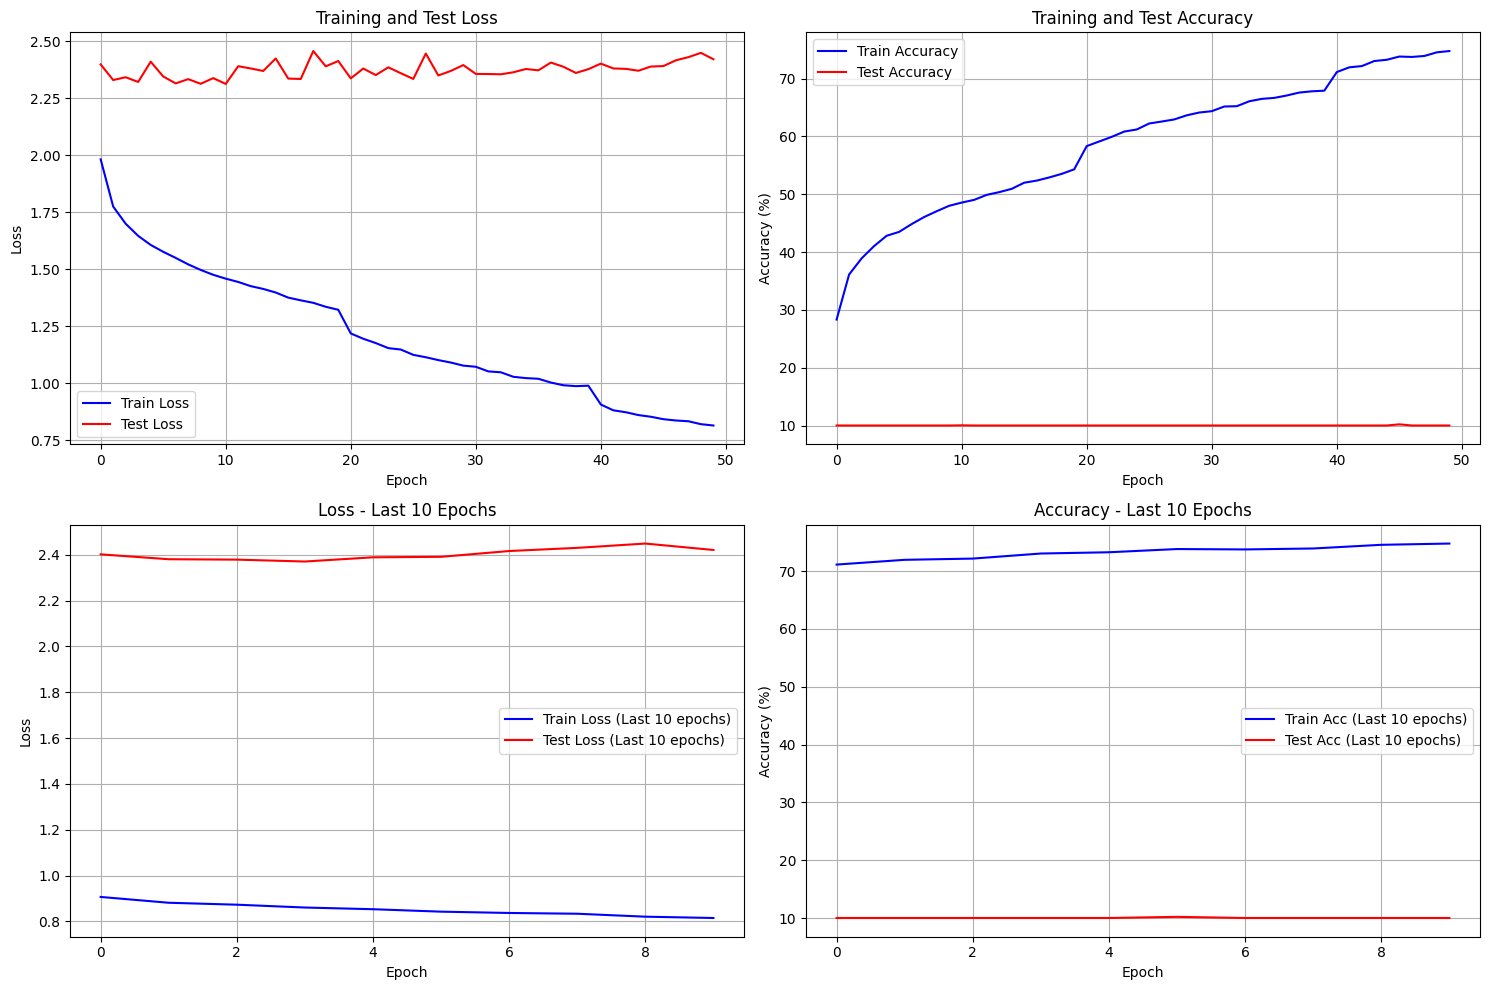

Performing detailed evaluation...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Final Performance Metrics ===
Accuracy: 0.1000
F1-Score (Macro): 0.0182
F1-Score (Weighted): 0.0182
Precision (Macro): 0.0100
Precision (Weighted): 0.0100
Recall (Macro): 0.1000
Recall (Weighted): 0.1000


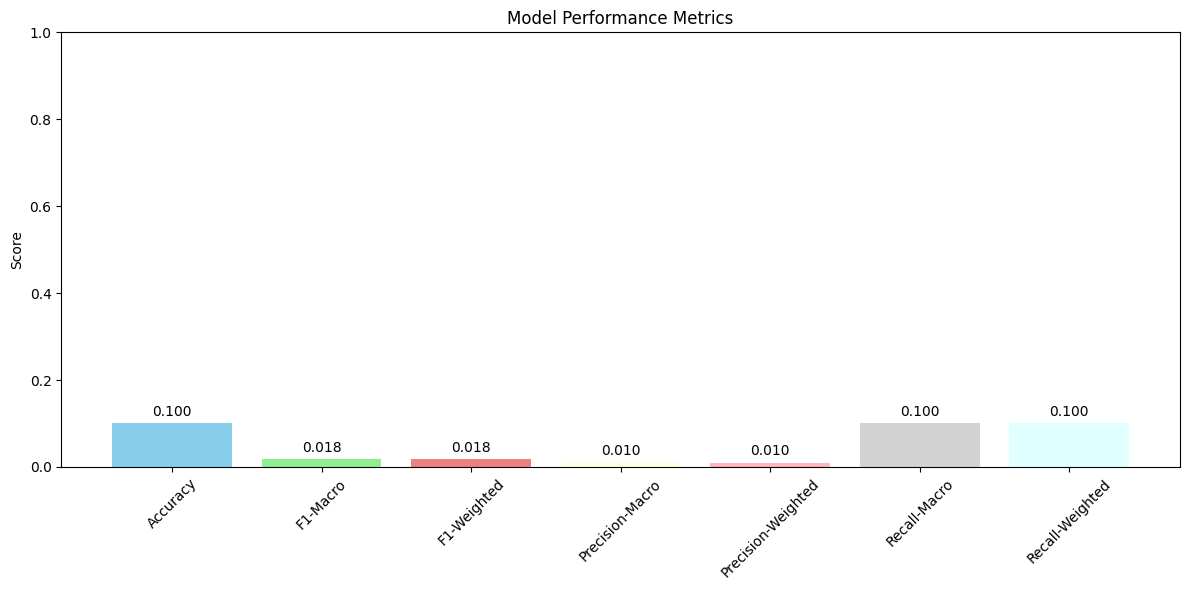


=== Classification Report ===
              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00      1000
  automobile       0.10      1.00      0.18      1000
        bird       0.00      0.00      0.00      1000
         cat       0.00      0.00      0.00      1000
        deer       0.00      0.00      0.00      1000
         dog       0.00      0.00      0.00      1000
        frog       0.00      0.00      0.00      1000
       horse       0.00      0.00      0.00      1000
        ship       0.00      0.00      0.00      1000
       truck       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from tqdm import tqdm
import seaborn as sns

# 전처리 함수
def input_preprocess(x, Aug=True):
    # AutoAugment는 uint8 텐서에서만 작동하므로 먼저 적용
    if Aug:
        x = T.AutoAugment(policy = T.AutoAugmentPolicy.CIFAR10, interpolation = T.InterpolationMode.NEAREST)(x)

    # 이후 float로 변환하고 정규화
    x = x.float()
    x /= 255.
    x = T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])(x)
    return x

# 라벨 스무딩 함수
def label_smooth(y, n_class):
    out = torch.ones(len(y), n_class)*(0.1/(n_class-1))
    for i in range(len(y)):
        out[i, y[i]] = 0.9
    return out.float()

# MLP 모델 정의
class MLPnet(nn.Module):
    def __init__(self, input_size=3*32*32, num_class=10):
        super(MLPnet, self).__init__()
        self.fc1 = nn.Linear(in_features = input_size, out_features=512)
        self.fc2 = nn.Linear(in_features = 512, out_features=512)
        self.fc3 = nn.Linear(in_features = 512, out_features=256)
        self.fc4 = nn.Linear(in_features = 256, out_features=256)
        self.fc5 = nn.Linear(in_features = 256, out_features=128)
        self.dropout = nn.Dropout(p=0.5)
        self.fc_last = nn.Linear(in_features = 128, out_features=num_class)
        self.auxil = nn.Linear(in_features = 512, out_features=num_class)
        self.batchnorm = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(256)
        self.batchnorm3 = nn.BatchNorm1d(128)

    def forward(self, x):
        x = torch.flatten(x, 1)
        first = self.batchnorm(F.gelu(self.fc1(x)))
        second = self.batchnorm(F.gelu(self.fc2(first))) + first
        third = self.batchnorm2(F.gelu(self.fc3(second)))
        fourth = self.batchnorm2(F.gelu(self.fc4(third))) + third
        x = self.batchnorm3(F.gelu(self.fc5(fourth)))
        x = self.dropout(x)
        out = self.fc_last(x)
        out_auxil = self.auxil(second)
        return out, out_auxil

# 데이터 로드
def load_cifar10_data(batch_size=128):
    # 훈련용 transform (augmentation 포함)
    train_transform = T.Compose([
        T.ToTensor(),  # 이미 uint8 -> float32로 변환하고 [0,1]로 스케일링
        T.Lambda(lambda x: (x * 255).byte()),  # 다시 uint8로 변환 (AutoAugment용)
        T.Lambda(lambda x: input_preprocess(x, Aug=True))
    ])

    # 테스트용 transform (augmentation 없음)
    test_transform = T.Compose([
        T.ToTensor(),
        T.Lambda(lambda x: input_preprocess(x, Aug=False))
    ])

    # 데이터셋 로드
    train_dataset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    test_dataset = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

    # 데이터로더 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader

# 학습 함수
def train_model(model, train_loader, test_loader, epochs=50, lr=0.001, device='cuda'):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        # 훈련
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)

            # 라벨 스무딩 적용
            smooth_target = label_smooth(target, 10).to(device)

            optimizer.zero_grad()
            output, auxil_output = model(data)

            # 메인 손실과 보조 손실 결합
            loss1 = F.kl_div(F.log_softmax(output, dim=1), smooth_target, reduction='batchmean')
            loss2 = F.kl_div(F.log_softmax(auxil_output, dim=1), smooth_target, reduction='batchmean')
            loss = loss1 + 0.3 * loss2

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = output.max(1)
            train_total += target.size(0)
            train_correct += predicted.eq(target).sum().item()

            pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*train_correct/train_total:.2f}%'
            })

        scheduler.step()

        # 훈련 지표 계산
        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = 100. * train_correct / train_total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)

        # 테스트
        test_loss, test_acc = evaluate_model(model, test_loader, device)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        print(f'Epoch {epoch+1}: Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

    return train_losses, train_accuracies, test_losses, test_accuracies

# 평가 함수
def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, _ = model(data)

            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

    test_loss /= total
    accuracy = 100. * correct / total

    return test_loss, accuracy

# 상세 평가 함수 (모든 지표 계산)
def detailed_evaluation(model, test_loader, device='cuda'):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output, _ = model(data)
            _, predicted = output.max(1)

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    # 성능 지표 계산
    accuracy = accuracy_score(all_targets, all_predictions)
    f1_macro = f1_score(all_targets, all_predictions, average='macro')
    f1_weighted = f1_score(all_targets, all_predictions, average='weighted')
    precision_macro = precision_score(all_targets, all_predictions, average='macro')
    precision_weighted = precision_score(all_targets, all_predictions, average='weighted')
    recall_macro = recall_score(all_targets, all_predictions, average='macro')
    recall_weighted = recall_score(all_targets, all_predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'predictions': all_predictions,
        'targets': all_targets
    }

# 그래프 그리기 함수
def plot_training_history(train_losses, train_accuracies, test_losses, test_accuracies):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Loss 그래프
    ax1.plot(train_losses, label='Train Loss', color='blue')
    ax1.plot(test_losses, label='Test Loss', color='red')
    ax1.set_title('Training and Test Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy 그래프
    ax2.plot(train_accuracies, label='Train Accuracy', color='blue')
    ax2.plot(test_accuracies, label='Test Accuracy', color='red')
    ax2.set_title('Training and Test Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    # Loss 확대 그래프 (마지막 10 에포크)
    if len(train_losses) > 10:
        ax3.plot(train_losses[-10:], label='Train Loss (Last 10 epochs)', color='blue')
        ax3.plot(test_losses[-10:], label='Test Loss (Last 10 epochs)', color='red')
        ax3.set_title('Loss - Last 10 Epochs')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Loss')
        ax3.legend()
        ax3.grid(True)

    # Accuracy 확대 그래프 (마지막 10 에포크)
    if len(train_accuracies) > 10:
        ax4.plot(train_accuracies[-10:], label='Train Acc (Last 10 epochs)', color='blue')
        ax4.plot(test_accuracies[-10:], label='Test Acc (Last 10 epochs)', color='red')
        ax4.set_title('Accuracy - Last 10 Epochs')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Accuracy (%)')
        ax4.legend()
        ax4.grid(True)

    plt.tight_layout()
    plt.show()

# 성능 지표 시각화 함수
def plot_metrics(metrics):
    metric_names = ['Accuracy', 'F1-Macro', 'F1-Weighted', 'Precision-Macro',
                   'Precision-Weighted', 'Recall-Macro', 'Recall-Weighted']
    metric_values = [metrics['accuracy'], metrics['f1_macro'], metrics['f1_weighted'],
                    metrics['precision_macro'], metrics['precision_weighted'],
                    metrics['recall_macro'], metrics['recall_weighted']]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(metric_names, metric_values, color=['skyblue', 'lightgreen', 'lightcoral',
                                                      'lightyellow', 'lightpink', 'lightgray', 'lightcyan'])
    plt.title('Model Performance Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)

    # 값 표시
    for bar, value in zip(bars, metric_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 메인 실행 함수
def main():
    # 디바이스 설정
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # 데이터 로드
    print("Loading CIFAR-10 dataset...")
    train_loader, test_loader = load_cifar10_data(batch_size=128)

    # 모델 생성
    model = MLPnet(input_size=3*32*32, num_class=10)
    print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")

    # 모델 학습
    print("Starting training...")
    train_losses, train_accuracies, test_losses, test_accuracies = train_model(
        model, train_loader, test_loader, epochs=50, lr=0.001, device=device
    )

    # 학습 과정 시각화
    print("Plotting training history...")
    plot_training_history(train_losses, train_accuracies, test_losses, test_accuracies)

    # 상세 평가
    print("Performing detailed evaluation...")
    metrics = detailed_evaluation(model, test_loader, device)

    # 결과 출력
    print("\n=== Final Performance Metrics ===")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1-Score (Macro): {metrics['f1_macro']:.4f}")
    print(f"F1-Score (Weighted): {metrics['f1_weighted']:.4f}")
    print(f"Precision (Macro): {metrics['precision_macro']:.4f}")
    print(f"Precision (Weighted): {metrics['precision_weighted']:.4f}")
    print(f"Recall (Macro): {metrics['recall_macro']:.4f}")
    print(f"Recall (Weighted): {metrics['recall_weighted']:.4f}")

    # 성능 지표 시각화
    plot_metrics(metrics)

    # 분류 리포트
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']
    print("\n=== Classification Report ===")
    print(classification_report(metrics['targets'], metrics['predictions'],
                              target_names=class_names))

    return model, metrics

# 실행
if __name__ == "__main__":
    model, metrics = main()

In [ ]:
# def input_preprocess(x, Aug=True):
#     if Aug:
#         x = T.AutoAugment(policy = T.AutoAugmentPolicy.CIFAR10, interpolation = T.InterpolationMode.NEAREST)(x)
#     x = x.float()
#     x /= 255.
#     x = T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])(x)
#     return x
# def label_smooth(y, n_class):
#     out = torch.ones(len(y), n_class)*(0.1/(n_class-1))
#     for i in range(len(y)):
#         out[i, y[i]] = 0.9

#     return out.float()
# class MLPnet(nn.Module):
#     def __init__(self, input_size=3*32*32, num_class=10):
#         super(MLPnet, self).__init__()
#         self.fc1 = nn.Linear(in_features = input_size, out_features=512)
#         self.fc2 = nn.Linear(in_features = 512, out_features=512)
#         self.fc3 = nn.Linear(in_features = 512, out_features=256)
#         self.fc4 = nn.Linear(in_features = 256, out_features=256)
#         self.fc5 = nn.Linear(in_features = 256, out_features=128)
#         self.dropout = nn.Dropout(p=0.5)
#         self.fc_last = nn.Linear(in_features = 128, out_features=num_class)
#         self.auxil = nn.Linear(in_features = 512, out_features=num_class)
#         self.batchnorm = nn.BatchNorm1d(512)
#         self.batchnorm2 = nn.BatchNorm1d(256)
#         self.batchnorm3 = nn.BatchNorm1d(128)

#     def forward(self, x):
#         x = torch.flatten(x, 1)
#         first = self.batchnorm(F.gelu(self.fc1(x)))
#         second = self.batchnorm(F.gelu(self.fc2(first))) + first
#         third = self.batchnorm2(F.gelu(self.fc3(second)))
#         fourth = self.batchnorm2(F.gelu(self.fc4(third))) + third
#         x = self.batchnorm3(F.gelu(self.fc5(fourth)))
#         x = self.dropout(x)
#         out = self.fc_last(x)
#         out_auxil = self.auxil(second)
#         return out, out_auxil

# # 학습 및 평가 + 그래프 저장
# def train_and_evaluate(model, train_loader, test_loader, model_name, dataset_name):
#     model.to(DEVICE)
#     optimizer = optim.SGD(model.parameters(), lr=LR, weight_decay=1e-4)
#     criterion = nn.CrossEntropyLoss()

#     train_losses = []
#     val_accuracies = []

#     for epoch in range(EPOCHS):
#         model.train()
#         running_loss = 0.0
#         for images, labels in train_loader:
#             images, labels = images.to(DEVICE), labels.to(DEVICE)
#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             running_loss += loss.item() * images.size(0)

#         avg_loss = running_loss / len(train_loader.dataset)
#         train_losses.append(avg_loss)

#         # Validation
#         model.eval()
#         correct = 0
#         total = 0
#         with torch.no_grad():
#             for images, labels in test_loader:
#                 images, labels = images.to(DEVICE), labels.to(DEVICE)
#                 outputs = model(images)
#                 _, predicted = torch.max(outputs, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()
#         accuracy = correct / total * 100
#         val_accuracies.append(accuracy)

#         print(f"[{dataset_name}] {model_name} Epoch {epoch+1}/{EPOCHS} - Loss: {avg_loss:.4f}, Val Acc: {accuracy:.2f}%")

#     # 그래프
#     plt.figure(figsize=(10,4))
#     plt.subplot(1,2,1)
#     plt.plot(train_losses, label='Train Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.title(f'{model_name} Train Loss ({dataset_name})')
#     plt.legend()

    # plt.subplot(1,2,2)
    # plt.plot(val_accuracies, label='Validation Accuracy')
    # plt.xlabel('Epoch')
    # plt.ylabel('Accuracy (%)')
    # plt.title(f'{model_name} Val Accuracy ({dataset_name})')
    # plt.legend()
    # plt.tight_layout()
    # plt.show()

    # return val_accuracies[-1]


# # 실행
# if __name__ == "__main__":
#     for dataset_name in ["FashionMNIST", "CIFAR10"]:
#         train_loader, test_loader, input_size = get_data_loaders(dataset_name)

#         model1 = MLPnet(input_size)
#         acc1 = train_and_evaluate(model1, train_loader, test_loader, "MLPnet", dataset_name)

